In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [48]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from functools import reduce
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [49]:
pd.set_option("display.max_columns", None)

In [50]:
# nusiskaitau parsisiustus failus ir sudedu ju path'us i lista
raw_data_directory = "/content/drive/MyDrive/raw_data/"
csv_files_receptai = [
    raw_data_directory + file
    for file in os.listdir(raw_data_directory)
    if file.endswith(".csv") and file.startswith("espbi")
]

In [51]:
# nuskaitau duomenu rinkinio pozymiu aprasymo faila, kadangi kai kurie aprasymai ilgi, nustatau maksimalu column width
data_desc = pd.read_csv(
    "/content/drive/MyDrive/raw_data/e_receptas_struktura_x.csv", delimiter=";"
)
pd.set_option("max_colwidth", None)
data_desc

,column_name,column_description
0,dirbt_recepto_id,dirbtinis išrašyto recepto identifikatorius
1,recepto_metai,recepto išrašymo metai
2,recepto_ketv,recepto išrašymo ketvirtis
3,ligos_kodas,"diagnozės (pagal TLK-10-AM klasifikatorių), pagal kurią išrašytas receptas, kodas"
4,ligos_pav,"diagnozės (pagal TLK-10-AM klasifikatorių), pagal kurią išrašytas receptas, pavadinimas"
5,vaisto_tipas,"skirto vaisto tipas (vaistas, medicinos pagalbos priemonė (MPP), vardinis vaistas, ekstemporalus vaistas, kitos priemonės)"
6,vaisto_bendr_pav,"skiriamo vaisto (vardinio vaisto bendrinis pavadinimas, ekstemporaliam vaistui gaminti naudojamos pagrindinės veikliosios medžiagos pavadinimas) bendrinis pavadinimas"
7,vaisto_prek_pav,skiriamo vaisto (vardinio vaisto MPP) prekinis pavadinimas
8,atc_kodas,skiriamo vaisto* ATC kodas
9,atc_pav,skiriamo vaisto ATC pavadinimas


In [52]:
# nuskaitau kiekviena faila i pandas dataframe ir sukuriu dataframe'u lista
df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]

# sukuriu bendra dataframe sujungdamas visus df esancius df list'e
raw_joined_df = reduce(lambda df1, df2: pd.concat([df1, df2]), df_list_receptai)

<ipython-input-52-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-52-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-52-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-52-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-52-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,31) have mixed types. Specify dtype option on i

In [53]:
# kadangi nagrinesiu duomenis noredamas nuspeti ar zmones pasinaudos receptu ar ne, pasalinu reiksmes active (receptas galioja ir dar nepanaudotas) ir
# on hold (vaistai pagal recepta rezervuoti)
# taip pat neatveriama, kas nesuteikia informacijos apie recepto panaudojima
receptai_df = raw_joined_df.query(
    """ recepto_statusas == 'completed' | recepto_statusas == 'stopped' """
)

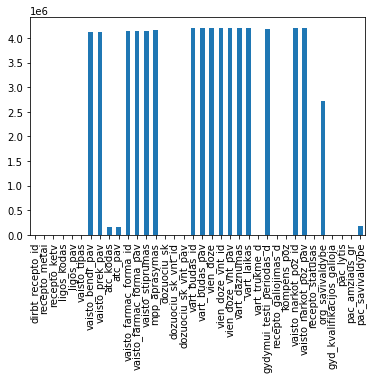

In [54]:
# turiu stulpelius, kuriu beveik visos reiksmes yra nezinomos, siu stulpeliu atsisakau
receptai_df.isna().sum().plot(kind="bar")
plt.show()

In [55]:
receptai_df = receptai_df.drop(
    [
        "vaisto_bendr_pav",
        "vaisto_prek_pav",
        "vaisto_farmac_forma_id",
        "vaisto_farmac_forma_pav",
        "vaisto_stiprumas",
        "mpp_aprasymas",
        "vart_budas_id",
        "vart_budas_pav",
        "vien_doze",
        "vien_doze_vnt_id",
        "vien_doze_vnt_pav",
        "vart_daznumas",
        "vart_laikas",
        "gydymui_testi_periodas_d",
        "vaisto_narkot_poz_id",
        "vaisto_narkot_poz_pav",
        "org_savivaldybe",
    ],
    axis=1,
)

In [56]:
# pakeiciu recepto statusa completed i 1 ir stopped i 0
receptai_df["recepto_statusas"] = receptai_df["recepto_statusas"].replace(
    {"completed": 1, "stopped": 0}
)

In [59]:
# pakeiciu datatype stulpeliu, kurie turi float datatype, bet atspindi sveikus skaicius, i integer
receptai_df[
    [
     'dozuociu_sk', 
     'recepto_galiojimas_d', 
     'kompens_poz', 
     'vart_trukme_d'
     ]] = receptai_df[
         [
             'dozuociu_sk', 
             'recepto_galiojimas_d', 
             'kompens_poz', 
             'vart_trukme_d']
         ].astype(int)

In [60]:
# kad sumazinti scope'a, susikuriu list'a kuris talpina 100 dazniausiai pasikartojanciu ligu kodu
top_100_ligos = [x for x in receptai_df["ligos_kodas"].value_counts().head(100).index]

In [61]:
# issifiltruoju duomenis pagal top 100 ligos kodu
receptai_df = receptai_df[receptai_df["ligos_kodas"].isin(top_100_ligos)]

1    2825802
0     446422
Name: recepto_statusas, dtype: int64

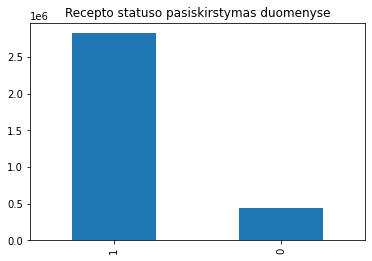

In [63]:
# duomenu rinkinys yra labai isbalansuotas
ax = receptai_df["recepto_statusas"].value_counts().plot(kind="bar")
ax.set_title("Recepto statuso pasiskirstymas duomenyse")
receptai_df["recepto_statusas"].value_counts()

In [65]:
# kad isspresti auksciau matoma problema, susikuriu nauja, subalansuota duomenu rinkini
df_negative = receptai_df.query(" recepto_statusas == 0").sample(300000)
df_possitive = receptai_df.query(" recepto_statusas == 1").sample(300000)

df_receptai_balanced = pd.concat([df_possitive, df_negative], axis=0)

In [66]:
# pasalinu is atminties nuskaitytus raw duomenis ir apdirbtus duomenis, kad atlaisvinti atminties modelio treniravimui
del raw_joined_df
del receptai_df

In [78]:
df_receptai_balanced

,dirbt_recepto_id,recepto_metai,recepto_ketv,ligos_kodas,ligos_pav,vaisto_tipas,atc_kodas,atc_pav,dozuociu_sk,dozuociu_sk_vnt_id,dozuociu_sk_vnt_pav,vart_trukme_d,recepto_galiojimas_d,kompens_poz,recepto_statusas,gyd_kvalifikacijos_galioja,pac_lytis,pac_amziaus_gr,pac_savivaldybe
265987,49388551886148033,2022,1,I20.8,Kitos krūtinės anginos formos,Vaistas,C01EB15,Trimetazidine,120,5738.0,tabletė,60,29,1,1,Šeimos gydytojas,M,Nuo 65 m.,Kauno r. sav.
29974,49532144021738389,2022,1,I50.0,Stazinis širdies nepakankamumas,Vaistas,C03CA04,Torasemide,90,5738.0,tabletė,90,29,1,1,Vidaus ligų gydytojas,V,Nuo 65 m.,Vilniaus m. sav.
70285,49468484349206379,2022,1,J01.9,"Ūminis sinusitas, nepatikslintas",Vaistas,R01BA52,"Pseudoephedrine, combinations",10,5738.0,tabletė,10,29,0,1,Šeimos gydytojas,M,18-44 m.,Panevėžio m. sav.
442279,49544080492441377,2022,1,F41.9,Nepatikslintas nerimo sutrikimas,Vaistas,N05BA12,Alprazolam,30,5738.0,tabletė,30,29,0,1,Vidaus ligų gydytojas,M,Nuo 65 m.,Rokiškio r. sav.
67088,49476125385101509,2022,1,F20.0,Paranoidinė šizofrenija,Vaistas,N05AD01,Haloperidol,90,5738.0,tabletė,90,29,1,1,"Gydytojas psichiatras, Gydytojas vaikų ir paauglių psichiatras",M,18-44 m.,Vilniaus m. sav.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147294,49427611846425731,2022,1,Z71.8,Kitas patikslintas konsultavimas,Vaistas,V03AB21,Potassium iodide,4,5738.0,tabletė,2,29,0,0,Bendrosios praktikos slaugytojas,M,18-44 m.,Vilniaus m. sav.
232193,49455916774226394,2022,1,J20.9,"Ūminis bronchitas, nepatikslintas",Vaistas,R03AC02,Salbutamol,1,5716.0,flakonas,14,28,0,0,Vidaus ligų gydytojas,M,45-64 m.,Kauno m. sav.
619904,49431823418712488,2022,1,J44.8,Kita patikslinta lėtinė obstrukcinė plaučių liga,Vaistas,R03AL,Adrenergics in combination with anticholinergics incl. triple combinations with corticosteroids,120,5715.0,dozė,30,29,1,0,Šeimos gydytojas,V,Nuo 65 m.,Vilniaus m. sav.
466571,49507573149079546,2022,1,K21.9,Gastroezofaginio refliukso liga be ezofagito,Vaistas,A05BA03,Silymarin,60,5721.0,kapsulė,30,28,0,0,Gydytojas gastroenterologas,M,Nuo 65 m.,Biržų r. sav.


In [67]:
# apsibreziu features ir target variable
X = df_receptai_balanced[
    [
        "ligos_kodas",
        "atc_kodas",
        "dozuociu_sk",
        "recepto_galiojimas_d",
        "kompens_poz",
        "pac_savivaldybe",
        "vart_trukme_d",
        "pac_lytis",
        "pac_amziaus_gr",
    ]
]

y = df_receptai_balanced["recepto_statusas"]

# Preprocessing

In [68]:
# is pasirinktu features'u apsibreziu du kintamuosius atskiriant categorical ir numeric features'us
numeric_features = [col for col in X.select_dtypes(include=["float", "int"]).columns]
categorical_features = [col for col in X.select_dtypes(exclude=["float", "int"]).columns]

# pipeline numeric features'u imputinimui ir scalinimui
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", StandardScaler())]
)

# pipeline categorical features'u imputinimui ir scalinimui
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ]
)

# preprocessor pipeline feature'ams sutvarkyti
preprocessor_pipeline = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)
# parodoma preprocess pipeline
print(""" Preprocessing'o pipeline: """)
preprocessor_pipeline

 Preprocessing'o pipeline: 


ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['dozuociu_sk', 'recepto_galiojimas_d',
                                  'kompens_poz', 'vart_trukme_d']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['ligos_kodas', 'atc_kodas', 'pac_savivaldybe',
                                  'pac_lytis', 'pac_amziaus_gr'])])

In [69]:
# dataframe po preprocessinimo, gaunu 946 features
pd.DataFrame(preprocessor_pipeline.fit_transform(X))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945
0,0.568749,-0.015309,1.065205,0.370123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [70]:
# split'inu duomenis i train ir test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [71]:
# is savo train duomenu rinkinio susikuriu validation duomenu rinkini
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Hyperparameter Tuning and Algorithm Selection

In [79]:
# apsibreziu hyperparametrus, kurious noriu tunint RandomForestClassifier algoritmui
params_rfc = {
    "max_depth": list(np.arange(10, 100, step=10)) + [None],
    "n_estimators": np.arange(10, 500, step=50),
    "max_features": randint(1, 7),
    "min_samples_leaf": randint(1, 4),
    "min_samples_split": np.arange(2, 10, step=2),
}

# susikuriu random forest classifier objekta
rfc = RandomForestClassifier(n_jobs=-1)

# susikuriu randomized search objekta
rfc_random = RandomizedSearchCV(
    rfc, params_rfc, n_iter=5, scoring="accuracy", n_jobs=-1, cv=3
)

# fit'inu randomized search objekta su duomenimis, pritaikau preprocessinimo pipeline apdirbti features
model_rfc_random = rfc_random.fit(
    pd.DataFrame(preprocessor_pipeline.fit_transform(X_val)), y_val
)

# grazinu geriausius hyperparametru nustatymus ir geriausia pasiekta tiksluma
print("Best hyperparameters are: " + str(model_rfc_random.best_params_))
print("Best score is: " + str(model_rfc_random.best_score_))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best hyperparameters are: {'max_depth': 70, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 260}
Best score is: 0.7664166666666666


In [ ]:
# apsibreziu hyperparametrus, kurious noriu tunint DecisionTreeClassifier algoritmui
params_dtc = {
    "max_depth": [3, None],
    "max_features": randint(1, 10),
    "min_samples_leaf": randint(1, 10),
    "min_samples_split": randint(2, 20),
    "criterion": ["gini", "entropy"],
}

# # susikuriu decision tree classifier objekta
dtc = DecisionTreeClassifier()

# susikuriu randomized search objekta
dtc_random = RandomizedSearchCV(dtc, params_dtc, n_iter=5, cv=3, n_jobs=-1)

# fit'inu randomized search objekta su duomenimis, pritaikau preprocessinimo pipeline apdirbti features
model_dtc_random = dtc_random.fit(
    pd.DataFrame(preprocessor_pipeline.fit_transform(X_val)), y_val
)

# grazinu geriausius hyperparametru nustatymus ir geriausia pasiekta tiksluma
print("Best hyperparameters are: " + str(model_dtc_random.best_params_))
print("Best score is: " + str(model_dtc_random.best_score_))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best hyperparameters are: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 16}
Best score is: 0.750093616335142


# Feature Selection and Training

In [81]:
# apsibreziu RFE objekta (recursive feature eliminator), kuri nadosiu final pipeline'e, kad issirinkti 350 labiausiai reiksme turincius features'u
rfe_estimator = LinearRegression(n_jobs=-1)

selector = RFE(rfe_estimator, n_features_to_select=350, step=50)

# apsibreziu DecisionTreeClassifier objekta, kuri naudosiu final pipeline, kad atlikti klasifikacija
forest_clf = RandomForestClassifier(
    n_jobs=-1,
    max_depth=model_rfc_random.best_params_["max_depth"],
    max_features=model_rfc_random.best_params_["max_features"],
    min_samples_leaf=model_rfc_random.best_params_["min_samples_leaf"],
    min_samples_split=model_rfc_random.best_params_["min_samples_split"],
    n_estimators=model_rfc_random.best_params_["n_estimators"],
)

# dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, max_features = 4, min_samples_leaf = 1, min_samples_split = 18)

In [82]:
classification_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_pipeline),
        ("feature_selector", selector),
        ("classifier", forest_clf),
    ]
)

print("This is the final pipeline:")
classification_pipeline

This is the final pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dozuociu_sk',
                                                   'recepto_galiojimas_d',
                                                   'kompens_poz',
                                                   'vart_trukme_d']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['ligos_kodas', 'atc_kodas',
                                                   'pac_savivaldybe',
                                                   'pac_lytis',
                                                   'pac_amziaus_gr'])])),
                ('feature_selector',
                 RFE(estimator=LinearRegression(n_jobs=-1),
                     n_features_to_select=350, step=50)),
                ('classifier',
                 RandomForestClassifier(max_depth=70, max_features=1,
                                        min_samples_split=4, n_estimators=260,
                                        n_jobs=-1))])

In [83]:
# fit'inu train duomenis ir apmokau modeli
classification_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dozuociu_sk',
                                                   'recepto_galiojimas_d',
                                                   'kompens_poz',
                                                   'vart_trukme_d']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['ligos_kodas', 'atc_kodas',
                                                   'pac_savivaldybe',
                                                   'pac_lytis',
                                                   'pac_amziaus_gr'])])),
                ('feature_selector',
                 RFE(estimator=LinearRegression(n_jobs=-1),
                     n_features_to_select=350, step=50)),
                ('classifier',
                 RandomForestClassifier(max_depth=70, max_features=1,
                                        min_samples_split=4, n_estimators=260,
                                        n_jobs=-1))])

In [84]:
# return'inu modelio score ir klasifikavimo reporta
print("Model score: ", classification_pipeline.score(X_test, y_test).round(3))
pred_tree = classification_pipeline.predict(X_test)
print(
    classification_report(
        y_test, pred_tree, target_names=[str(x) for x in y.unique()].sort()
    )
)

Model score:  0.734
              precision    recall  f1-score   support

           0       0.76      0.69      0.72     60000
           1       0.71      0.78      0.75     60000

    accuracy                           0.73    120000
   macro avg       0.74      0.73      0.73    120000
weighted avg       0.74      0.73      0.73    120000



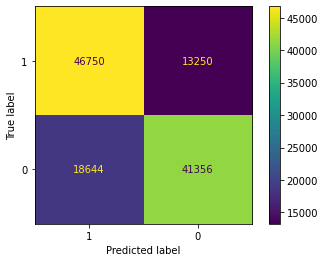

In [85]:
# confusion matrix
conf_matrx = confusion_matrix(
    y_test, classification_pipeline.predict(X_test), labels=y.unique()
)
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrx, display_labels=y.unique())

display.plot()

In [87]:
# susigeneruoju modelio faila naudodams pickle biblioteka, si faila naudosiu modelio deploy'inimo zingsnyje
with open("model.pkl", "wb") as f:
    pickle.dump(classification_pipeline, f)